# Build train and test matrices

In [1]:
import pandas as pd
import numpy as np
import feather

df = (feather.read_dataframe('/home/SHARED/SOLAR/data/oahu_min.feather')
             .set_index('Datetime'))

/home/victor/miniconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:742: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [2]:
# https://stackoverflow.com/questions/15722324/sliding-window-in-numpy
def window_stack_forward(a, stepsize=1, width=3):
    return np.hstack( a[i:1+i-width or None:stepsize] for i in range(0, width) )

In [3]:
# I feel this function can also be done for pd.DataFrame
def window_stack(a, width=3):
    n = a.shape[0]
    return np.hstack(list(a[(width-1-i):(n-i)] for i in range(0, width)))

In [4]:
# In pandas 0.24, use df.to_numpy() instead of df.values. Also care with non-numeric columns
width = 61
a = window_stack(df.values, width=width)

In [5]:
times   = [ ('t' if not idx else 't-{:d}'.format(idx)) for idx in range(width) ]
columns = pd.MultiIndex.from_product((times, df.columns), names=('time', 'location'))

In [6]:
# Convert back to DataFrame, just for convenience of having indexes
df_roll = pd.DataFrame(a, index=df.index[width-1:], columns=columns)

In [7]:
# Split target (time t) and variables (times t-1 to t-width+1)
y = df_roll['t']
X = df_roll.drop(columns='t', level='time')

In [8]:
# Split train-test, approximately 12 and 4 months respectively
X_train, X_test = X[:'2011-07-31'], X['2011-08-01':]
y_train, y_test = y[:'2011-07-31'], y['2011-08-01':]

In [9]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(449885, 1140)
(82892, 1140)
(449885, 19)
(82892, 19)


# Naive predictor

We compute the error while predicting with the inmediately previous observation, for each sensor

In [22]:
y_pred = np.zeros_like(y_test.values)
y_pred = X_test['t-1']

In [40]:
y_pred.columns

Index(['GH_DH3', 'GH_DH4', 'GH_DH5', 'GH_DH10', 'GH_DH11', 'GH_DH9', 'GH_DH2',
       'GH_DH1', 'GT_DH1', 'GH_AP6', 'GT_AP6', 'GH_AP1', 'GH_AP3', 'GH_AP5',
       'GH_AP4', 'GH_AP7', 'GH_DH6', 'GH_DH7', 'GH_DH8'],
      dtype='object', name='location')

In [27]:
from sklearn.metrics import mean_absolute_error

In [57]:
mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
mae = pd.Series(mae, index=y_test.columns)
mae.sort_values()

location
GH_AP3      0.000000
GT_DH1     43.546326
GT_AP6     45.910107
GH_DH2     55.875255
GH_DH1     56.050096
GH_DH4     56.824072
GH_AP7     57.005657
GH_DH11    57.096757
GH_DH10    57.214625
GH_DH8     57.261513
GH_DH7     57.296253
GH_AP4     57.439284
GH_DH5     57.471329
GH_AP1     57.739932
GH_DH6     58.379390
GH_AP5     58.714546
GH_DH9     59.378966
GH_DH3     60.004030
GH_AP6     60.582939
dtype: float64

# Convolutional predictor


In [211]:
X_tr1 = X_train['t-1']
y_tr1 = y_train

In [212]:
X_te1 = X_test['t-1']
y_te1 = y_test

In [63]:
%matplotlib inline
res = pd.DataFrame({'Actual': y_test['GT_DH1'], 'Pred': y_test['GH_DH1']})

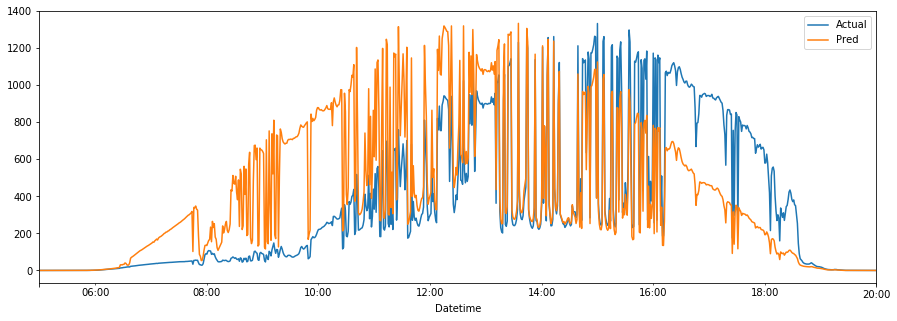

In [66]:
res['20110806'].plot(figsize=(15, 5));

In [128]:
info = pd.read_csv('/home/SHARED/SOLAR/data/info.csv')

In [134]:
info.Location = info.Location.apply(lambda x: (x[:2] + x[-2:]).replace('_', ''))

In [135]:
info.index = info.Location

In [136]:
longs = info['       Longitude'].sort_values(ascending=False)

In [137]:
longs

Location
AP7    -158.07785
AP6    -158.07935
AP4    -158.07947
AP3    -158.08163
AP5    -158.08249
AP1    -158.08389
DH5    -158.08424
DH3    -158.08463
DH4    -158.08505
DH11   -158.08530
DH2    -158.08534
DH10   -158.08554
DH8    -158.08675
DH6    -158.08678
DH7    -158.08685
DH9    -158.08688
DH1    -158.08700
Name:        Longitude, dtype: float64

In [213]:
X_tr1.drop('GT_AP6', inplace=True, axis=1)
y_tr1.drop('GT_AP6', inplace=True, axis=1)

/home/victor/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [214]:
X_tr1.drop('GT_DH1', inplace=True, axis=1)
y_tr1.drop('GT_DH1', inplace=True, axis=1)

/home/victor/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [216]:
X_tr1.shape, y_tr1.shape

((449885, 17), (449885, 17))

In [229]:
homogen_name = lambda x: x[-4:].replace('_', '')

X_tr1.columns = [homogen_name(x) for x in X_tr1.columns.values.tolist()]
y_tr1.columns = [homogen_name(x) for x in y_tr1.columns.values.tolist()]

In [230]:
X_tr1_1 = X_tr1[longs.index]
y_tr1_1 = y_tr1[longs.index]

In [231]:
# Some other ordenations...

In [232]:
def generator(batch_size):
    while True:
        for ((_,g),(_,gy)) in zip( X_tr1_1.groupby(np.arange(len(X_tr1_1))//batch_size), y_tr1_1.groupby(np.arange(len(y_tr1_1))//batch_size)):
            # Perform channeling here
            yield (g,gy)

In [235]:
for g,v in generator(2):
    print(g.values.shape, v.values.shape)
    break

(2, 17) (2, 17)


# Train Elastic Net model

In [10]:
from contextlib import contextmanager
from timeit import default_timer

@contextmanager
def timer(tag=None):
    start = default_timer()
    try:
        yield
    finally:
        end = default_timer()
        print(('[{}] '.format(tag) if tag else '') +
               'Elapsed time (s): {:.6f}'.format(end - start))

In [11]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import TimeSeriesSplit

enet = ElasticNetCV(n_jobs=10, cv=TimeSeriesSplit(n_splits=5), l1_ratio=0.5)
with timer():
    enet.fit(X_train, y_train['GH_AP1'])

Elapsed time (s): 646.287442


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [12]:
print('R^2 (train): {}'.format(enet.score(X_train, y_train['GH_AP1'])))
print('R^2 (test): {}'.format(enet.score(X_test, y_test['GH_AP1'])))
print('alpha: {}'.format(enet.alpha_))
print('l1_ratio: {}'.format(enet.l1_ratio_))

R^2 (train): 0.8996642313321442
R^2 (test): 0.8810550943484787
alpha: 229.09871455104192
l1_ratio: 0.5


In [13]:
%matplotlib inline
res = pd.DataFrame({'Actual': y_test['GH_AP1'], 'Pred': enet.predict(X_test)})

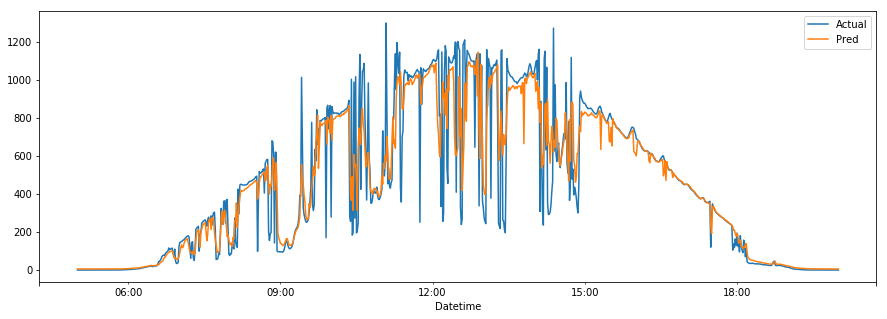

In [14]:
res['20110801'].plot(figsize=(15, 5));

In [15]:
from sklearn.metrics import mean_absolute_error

In [16]:
res['abs_error'] = res['Actual'].sub(res['Pred']).abs()

In [17]:
res['abs_error'].mean()

56.42577223776865

In [18]:
from sklearn.linear_model import MultiTaskElasticNetCV
from sklearn.multioutput import MultiOutputRegressor

enet = MultiOutputRegressor(ElasticNetCV(cv=TimeSeriesSplit(n_splits=5), l1_ratio=0.5), n_jobs=10)
with timer():
    enet.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

Elapsed time (s): 4048.463773


In [27]:
y_test_pred = pd.DataFrame(enet.predict(X_test), index=y_test.index, columns=y_test.columns)

In [32]:
res = pd.concat((y_test, y_test_pred), axis=1, keys=['Actual', 'Pred'])

In [45]:
res.stack(level='location').groupby('location').apply(lambda s: mean_absolute_error(s['Actual'], s['Pred'])).sort_values()

location
GH_AP3     41.272833
GH_DH8     45.940841
GH_DH11    49.423486
GH_AP5     49.645268
GT_DH1     50.232415
GH_DH9     51.914226
GH_DH6     52.295803
GH_DH10    54.067657
GT_AP6     54.362009
GH_DH7     55.919909
GH_AP1     56.425772
GH_DH4     57.001618
GH_DH5     57.469298
GH_DH3     58.028241
GH_DH1     59.039559
GH_DH2     60.615344
GH_AP4     62.791843
GH_AP6     68.239365
GH_AP7     71.464025
dtype: float64

Conclusiones:
* Ajustar los 19 modelos ENet tarda poco más de 1h con `n_jobs=10`
* Parece que hay bastantes diferencias entre estaciones

**TODO**:
* Hacer un mapa de las estaciones coloreado por MAE, a ver si tienen alguna distribución espacial
* Probar otros modelos
* Normalizar las series temporales entre [0, 1]?
* Probar con distintos valores de `width`, como si fuera un hiperparámetro
* Ver sparsity
* Ajustar otros modelos (RandomForest, GradientBoosting, Neural Networks)

In [47]:
df.describe()

,GH_DH3,GH_DH4,GH_DH5,GH_DH10,GH_DH11,GH_DH9,GH_DH2,GH_DH1,GT_DH1,GH_AP6,GT_AP6,GH_AP1,GH_AP3,GH_AP5,GH_AP4,GH_AP7,GH_DH6,GH_DH7,GH_DH8
count,532837.000000,532837.000000,532837.000000,532837.000000,532837.000000,532837.000000,532837.000000,532837.000000,532837.000000,532837.000000,532837.000000,532837.000000,532837.000000,532837.000000,532837.000000,532837.000000,532837.000000,532837.000000,532837.000000
mean,376.638750,370.034010,373.901195,374.273224,371.089837,374.772595,370.716366,369.618733,315.318571,375.733485,308.801022,369.002688,322.606723,373.845794,370.204234,375.590406,374.534719,376.029534,370.716376
std,362.964985,350.421419,354.759126,353.021138,351.115238,363.056479,351.535268,349.439053,352.513236,355.910431,336.893122,347.831176,295.782851,355.027967,348.719699,357.166830,354.640874,356.311609,351.467618
min,-0.472400,-0.392927,-0.350097,-0.361164,-0.386116,-0.472512,-0.711078,-0.358951,-0.409680,-0.390316,-0.364171,0.000000,0.000000,0.000000,-0.358721,-0.389675,-0.383402,-0.382509,-0.392466
25%,35.866100,39.654200,39.543000,40.775900,38.551100,35.411500,36.950300,36.569700,29.477700,39.798900,33.856200,40.013500,138.069000,39.775800,40.156700,37.754700,39.172700,40.141100,39.567900
50%,274.736000,276.848000,278.847000,281.729000,278.481000,271.122000,276.924000,277.451000,166.047000,281.771000,174.568000,278.183000,234.346000,279.015000,279.661000,279.862000,280.325000,280.463000,277.053000
75%,635.739000,624.226000,630.812000,631.830000,625.551000,633.216000,626.999000,625.359000,530.037000,633.694000,511.336000,622.964000,424.807000,629.598000,624.808000,635.345000,632.643000,635.162000,624.791000
max,1666.880000,1700.350000,1655.720000,1651.900000,1627.110000,1697.560000,1699.410000,1588.720000,1587.020000,1580.340000,1542.840000,1593.990000,1657.880000,1648.220000,1574.890000,1612.970000,1584.890000,1627.860000,1610.440000
